# Analysis experiment 1: default values

The goal of the first experiment is to find sensible default values, based on performance data of random hyperparameter settings across different datasets.

In [1]:
import hyperimp.evaluate.default_params as hyperimp
import pandas as pd
from scipy.io import arff
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

In [112]:
# load data
svm = pd.DataFrame(arff.loadarff('01 data/exp1/meta_svm.arff')[0])
#svm_jan = pd.DataFrame(arff.loadarff('01 data/exp1/meta_svm_jan.arff')[0])
#svm = svm_jan
svm['kernel'] = svm['kernel'].str.decode('utf-8')
svm['shrinking'] = svm['shrinking'].str.decode('utf-8').map({'True' : True, 'False' : False})
#svm = svm[svm['kernel'] == 'rbf']

rf = pd.DataFrame(arff.loadarff('01 data/exp1/meta_rf.arff')[0])
rf['bootstrap'] = rf['bootstrap'].str.decode("utf-8").map({'True' : True, 'False' : False})
rf['criterion'] = rf['criterion'].str.decode("utf-8")

In [118]:
for i in range(0,10):
    print(rf['bootstrap'][i])
    print(type((rf['bootstrap'][i])))

False
<class 'numpy.bool_'>
True
<class 'numpy.bool_'>
True
<class 'numpy.bool_'>
True
<class 'numpy.bool_'>
False
<class 'numpy.bool_'>
False
<class 'numpy.bool_'>
False
<class 'numpy.bool_'>
False
<class 'numpy.bool_'>
True
<class 'numpy.bool_'>
True
<class 'numpy.bool_'>


In [36]:
# algorithms to be evaluated
alg_names = ['rf', 'svm']
# hyperparameters to be evaluated
alg_params = {'svm': ['gamma','C','tol', 'shrinking'],
              'rf': ['bootstrap', 'criterion', 'max_features','min_samples_leaf','min_samples_split']}
# parameters defined on a log and integer scale
logs = ['gamma', 'C', 'tol']
integer = ['min_samples_leaf', 'min_samples_split']
boolnom = ['bootstrap', 'criterion', 'shrinking']

## Distribution of top _n_ per hyperparameter

The intuition behind our method of finding default values, is to find the hyperparameter value that most often resulted in good performance. To this end, we first take a subset of the top _n_ performance data points of each dataset. Note that this subset contains _n_ * nr. of datasets datapoints. To get an idea of the distribution of the hyperparameters within the top _n_ dat points, we visualize them in a histogram.

In [40]:
n = 10
m = 40

# initialze alg objects
algs = hyperimp.init_algs('hyperimp/evaluate/parameters.csv', {'svm': svm, 'rf': rf})

# get top n data
dfs = [hyperimp.get_topn(alg, n, m, False) for alg in algs]

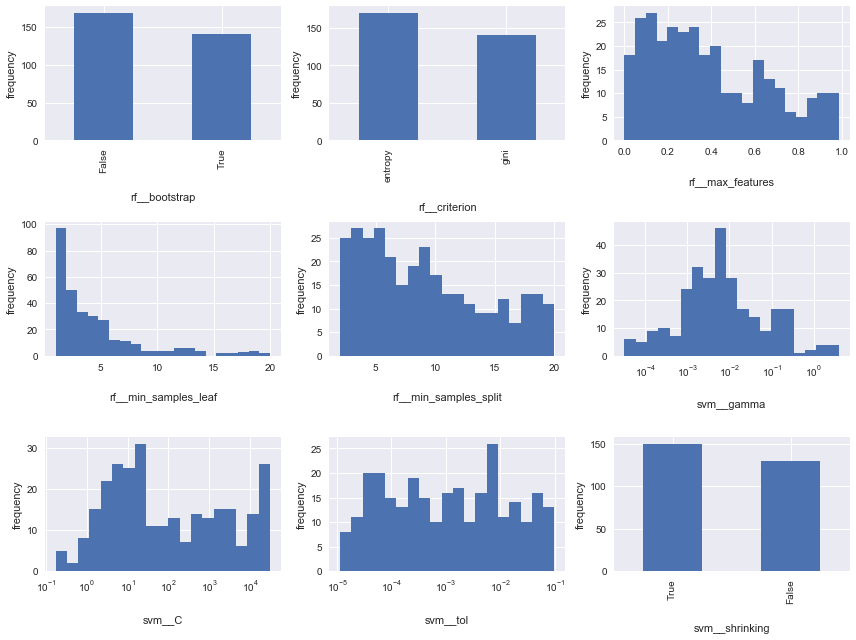

In [42]:
grid = True # put images on grid or not
cols = 3 # set nr columns in figure grid
ymax = None # set upper limit of plot; None for auto

if grid:
    nr_plots = sum([len(value) for key, value in alg_params.items()])
    rows = math.ceil(sum([len(value) for key, value in alg_params.items()])/cols)
    plt.figure(figsize = (4*cols,3*rows))
    index = 0
for alg, df in zip(alg_names, dfs):
    for param in alg_params[alg]:
        if grid:
            index += 1
            plt.subplot(rows, cols, index)
        if param in boolnom:
            df[param].value_counts().plot(kind='bar', color = sns.color_palette()[0])
        else:
            bins = 20
            log = param in logs
            intg = param in integer
            if log:
                bins = np.logspace(np.log10(min(df[param])), np.log10(max(df[param])), 20)
                plt.xscale('log', basex=10)
            if intg:
                bins = int(max(df[param]) - min(df[param]) + 1)
            plt.hist(df[param], bins = bins)
        plt.xlabel('%s__%s' % (alg, param), labelpad=20)
        plt.ylim(0,ymax)
        plt.ylabel('frequency')
        plt.tight_layout()
        if not grid:
            #plt.savefig('figures/histograms/hist__%s__%s.eps' % (alg, param), format = 'eps')
            plt.show()
if grid:
    plt.show()

## Meta-dependent features
For some hyperparameters, the default value in `sklearn` is dependent on the number of features $p$ in the datasets. The default of random forest's _max\_features_ is equal to $sqrt(p)$. The default of SVM's _gamma_ is equal to $1/p$.

In [94]:
from scipy.optimize import curve_fit
def func1(x, a):
    return a * x
def func2(x, a):
    return x ** a
def func3(x, a):
    return a**np.sqrt(x)
def func4(x, a):
    return 1/x
def func5(x, a):
    return 0.006
def func6(x,a):
    return x ** 0.25

def evaluate(x, y, popt):
    residuals = y - func(x, popt)
    ss_res = np.sum(residuals**2)
    rmse = np.sqrt(ss_res/len(x))
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res/ss_tot)
    return rmse, r_squared

def evaluate_log(x, y, popt):
    residuals = np.log(y + 1) - np.log(func(x, popt) + 1)
    ss_res = np.sum(residuals**2)
    rmsle = np.sqrt(ss_res/len(x))
    ss_tot = np.sum((np.log(y + 1) - np.mean(np.log(y + 1)))**2)
    r_squared_log = 1 - (ss_res/ss_tot)
    return rmsle, r_squared_log

### RandomForestClassifier's max\_features

Datasets with < 2000 features (31 datasets)
	 m = 0.24*n,	 	 RMSE: 45.92, 	 R2: 0.75, 	 RSMLE: 0.75, 	 LR2: 0.64
	 m = n^0.80,	 	 RMSE: 43.73, 	 R2: 0.77, 	 RSMLE: 0.77, 	 LR2: 0.62
	 m = 1.15^sqrt(n),	 RMSE: 65.85, 	 R2: 0.48, 	 RSMLE: 1.22, 	 LR2: 0.03
	 m = n^0.25,	 	 RMSE: 96.62, 	 R2: -0.12, 	 RSMLE: 1.62, 	 LR2: -0.71


/Users/hildeweerts/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


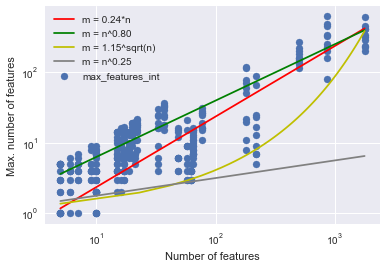

Datasets with < 200 features (27 datasets)
	 m = 0.28*n,	 	 RMSE: 10.35, 	 R2: 0.39, 	 RSMLE: 0.70, 	 LR2: 0.13
	 m = n^0.72,	 	 RMSE: 10.39, 	 R2: 0.39, 	 RSMLE: 0.63, 	 LR2: 0.29
	 m = 1.35^sqrt(n),	 RMSE: 10.49, 	 R2: 0.37, 	 RSMLE: 0.76, 	 LR2: -0.02
	 m = n^0.25,	 	 RMSE: 15.48, 	 R2: -0.37, 	 RSMLE: 1.19, 	 LR2: -1.54


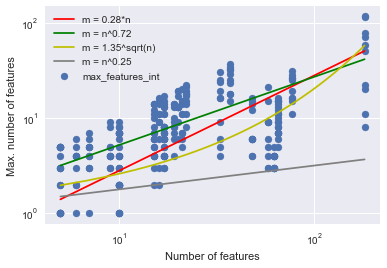

In [99]:
rf_topn = dfs[0]
rf_topn['max_features_int'] = np.ceil(rf_topn['max_features'] * rf_topn['NumberOfFeatures'])

for filter_val in [2000, 200]:
    rf_topn_f = rf_topn[rf_topn['NumberOfFeatures'] < filter_val]
    print("Datasets with < %s features (%s datasets)" % (filter_val, len(rf_topn_f['task_id'].unique())))
    x = rf_topn_f['NumberOfFeatures']
    y = rf_topn_f['max_features_int']
    plt.scatter(x,y)
    for func in [func1, func2, func3, func6]:
        popt, pcov = curve_fit(func, x, y)
        rmse, r_squared = evaluate(x, y, popt)
        rmsle, r_squared_log = evaluate_log(x, y, popt)
        x_plot = np.linspace(int(min(x)), int(max(x)), 100)
        if func == func1:
            print('\t m = %.2f*n,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (popt[0], rmse, r_squared, rmsle, r_squared_log))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = %.2f*n' %popt[0], c='r')
        elif func == func2:
            print('\t m = n^%.2f,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (popt[0], rmse, r_squared, rmsle, r_squared_log))
            #print('\t \t RMSE: %.2f, \t R2: %.2f'% (popt[0], rmse, r_squared))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = n^%.2f' %popt[0], c='g')
        elif func == func3:
            print('\t m = %.2f^sqrt(n),\t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (popt[0], rmse, r_squared, rmsle, r_squared_log))
            #print(',\t RMSE: %.2f, \t R2: %.2f'% (popt[0], rmse, r_squared))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = %.2f^sqrt(n)' %popt[0], c='y')
        elif func == func6:
            print('\t m = n^0.25,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (rmse, r_squared, rmsle, r_squared_log))
            #print('\t \t RMSE: %.2f, \t R2: %.2f'% (popt[0], rmse, r_squared))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = n^0.25' %popt[0], c='grey')
            
    plt.xlabel('Number of features')
    plt.ylabel('Max. number of features')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()


### SVM's gamma

Datasets with < 2000 features (28 datasets)
	 m = 0.00001*n,	 	 RMSE: 0.47, 	 R2: -0.06, 	 RSMLE: 0.23, 	 LR2: -0.10
	 m = 1/n,	 	 RMSE: 0.45, 	 R2: 0.02, 	 RSMLE: 0.21, 	 LR2: 0.06
	 m = 0.006,	 	 RMSE: 0.47, 	 R2: -0.05, 	 RSMLE: 0.23, 	 LR2: -0.08


/Users/hildeweerts/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


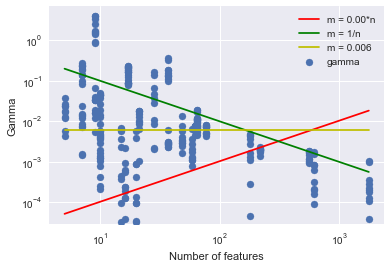

Datasets with < 200 features (24 datasets)
	 m = 0.00062*n,	 	 RMSE: 0.51, 	 R2: -0.06, 	 RSMLE: 0.24, 	 LR2: -0.11
	 m = 1/n,	 	 RMSE: 0.49, 	 R2: 0.01, 	 RSMLE: 0.23, 	 LR2: 0.04
	 m = 0.006,	 	 RMSE: 0.51, 	 R2: -0.06, 	 RSMLE: 0.24, 	 LR2: -0.10


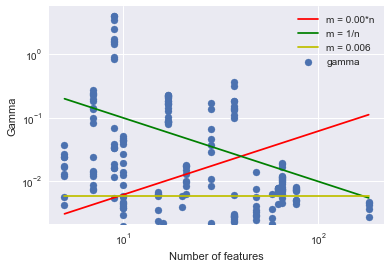

In [91]:
svm_topn = dfs[1]

for filter_val in [2000, 200]:
    svm_topn_f = svm_topn[svm_topn['NumberOfFeatures'] < filter_val]
    
    print("Datasets with < %s features (%s datasets)" % (filter_val, len(svm_topn_f['task_id'].unique())))
    x = svm_topn_f['NumberOfFeatures']
    y = svm_topn_f['gamma']
    plt.scatter(x,y)
    for func in [func1, func4, func5]:
        popt, pcov = curve_fit(func, x, y)
        rmse, r_squared = evaluate(x, y, popt)
        rmsle, r_squared_log = evaluate_log(x, y, popt)
        x_plot = np.linspace(int(min(x)), int(max(x)), 100)
        if func == func1:
            print('\t m = %.5f*n,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (popt[0], rmse, r_squared, rmsle, r_squared_log))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = %.2f*n' %popt[0], c='r')
        elif func == func4:
            print('\t m = 1/n,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (rmse, r_squared, rmsle, r_squared_log))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = 1/n', c='g')
        elif func == func5:
            print('\t m = 0.006,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (rmse, r_squared, rmsle, r_squared_log))
            plt.plot(x_plot, len(x_plot)*[0.006], label = 'm = 0.006', c='y')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of features')
    plt.ylabel('Gamma')
    plt.legend()
    plt.show()

## Default parameters

In [8]:
n = 10
m = 800

def_params_dict = {} # dictionary containing all default parameters for all algorithms
# requires parameters.csv (hyperimp/evaluate) and data in algs to be configured correctly!
for alg in algs:
    df = hyperimp.get_topn(alg, n, m, False)
    def_params = hyperimp.find_default(alg, df, False)
    def_params_df = pd.DataFrame(def_params).transpose()
    print('Average default value %s:' %alg.name)
    display(def_params_df.mean())
    print('Standard deviation default value %s:' %alg.name)
    display(def_params_df.std())
    display(def_params_df)
    if alg.name == 'rf':
        name = 'random_forest'
    elif alg.name == 'svm':
        name = 'svm'
    def_params_dict[name] = def_params
# save default parameter dictionary to pickle
with open('experiment_2/hyperimp/experiment/def_params.pickle', 'wb') as handle:
    pickle.dump(def_params_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Average default value rf:


bootstrap            0.000000
max_features         0.076245
min_samples_leaf     1.000000
min_samples_split    5.000000
dtype: float64

Standard deviation default value rf:


bootstrap            0.000000
max_features         0.003344
min_samples_leaf     0.000000
min_samples_split    0.000000
dtype: float64

,bootstrap,criterion,max_features,min_samples_leaf,min_samples_split
3.0,False,entropy,0.0749672,1,5
6.0,False,entropy,0.0816394,1,5
11.0,False,entropy,0.0816394,1,5
12.0,False,entropy,0.0953415,1,5
14.0,False,entropy,0.0816394,1,5
15.0,False,entropy,0.0816394,1,5
16.0,False,entropy,0.0816394,1,5
18.0,False,entropy,0.0749672,1,5
22.0,False,entropy,0.0816394,1,5
23.0,False,gini,0.0749672,1,5


Average default value svm:


C            3.880359
gamma        0.007236
shrinking    0.015152
tol          0.008680
dtype: float64

Standard deviation default value svm:


C            2.832199
gamma        0.000639
shrinking    0.000000
tol          0.002981
dtype: float64

,C,gamma,shrinking,tol
3.0,3.52991,0.00578691,True,0.00971299
6.0,3.52991,0.00627535,True,0.000107318
11.0,3.52991,0.00578691,True,0.00971299
12.0,3.52991,0.00752742,True,0.00971299
14.0,3.52991,0.00578691,True,0.000107318
15.0,3.52991,0.00752742,True,0.00971299
16.0,3.52991,0.00578691,True,0.00971299
18.0,3.52991,0.00578691,True,0.000107318
22.0,3.52991,0.00578691,True,0.00971299
23.0,3.52991,0.00752742,True,0.00971299


In [9]:
for alg in algs:
    topn = hyperimp.get_topn(alg, n, m, False)
    def_params = hyperimp.find_default(alg, topn, True)
    for key, value in hyperimp.default_score(alg, topn, def_params).items():
        print('%s \t %s : %f' %(alg.name, key, value))

rf 	 max_features : 0.300000
rf 	 min_samples_leaf : 0.433333
rf 	 min_samples_split : 0.122222
rf 	 criterion : 0.466667
rf 	 bootstrap : 0.533333
svm 	 gamma : 0.222222
svm 	 C : 0.177778
svm 	 tol : 0.122222
svm 	 shrinking : 0.527778
